# Solar PV tracking options
First of all import all relevant packages 

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import os

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/.conda/envs/atlite/share/proj failed


## Select Spain bounds for example

In [4]:
country_name = "Spain"
path = "Spain-2019"
year = "2019"
tmp_dir = os.path.join("./tmp_dir")

- use the shapereader of Cartopy to retrieve high resoluted shapes
- make a GeoSeries with the shapes

In [5]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)

country = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex([country_name])
country.unary_union.bounds

/home/jovyan/.conda/envs/atlite/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(-18.167225714999915, 27.642238674000055, 4.337087436000047, 43.79344310100004)

- create the cutout

In [6]:
cutout = atlite.Cutout(
    path=path,
    module="era5",
    bounds=country.unary_union.bounds,
    time=year,
)

cutout.prepare(tmpdir=tmp_dir)

/home/jovyan/work/pso-renewables-potential/renewables_potential Enrique/atlite/atlite/cutout.py:187: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "Spain-2019">
 x = -18.00 ⟷ 4.25, dx = 0.25
 y = 27.75 ⟷ 43.75, dy = 0.25
 time = 2019-01-01 ⟷ 2019-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

## Calculate capacity factors for the three solar pv tracking options

- tracking : None or str:
    - None for no tracking, default
    - 'vertical' for 1-axis vertical tracking
    - 'vh' for 2-axis tracking

- No tracking: 

In [7]:
cells = cutout.grid
cap_factors_pv_0axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cells,
    tracking=None,
    per_unit=True,
)

[########################################] | 100% Completed |  9.9s


- 1-axis vertical tracking

In [8]:
cap_factors_pv_1axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cells,
    tracking="vertical",
    per_unit=True,
)

[########################################] | 100% Completed |  5.9s


- 2-axis vertical tracking

In [9]:
cap_factors_pv_2axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cells,
    tracking="vh",
    per_unit=True,
)

[########################################] | 100% Completed |  5.7s


## Compare results

- average capacity factor

In [10]:
print(cap_factors_pv_0axis.mean())
print(cap_factors_pv_1axis.mean())
print(cap_factors_pv_2axis.mean())

<xarray.DataArray ()>
array(0.19215672)
<xarray.DataArray ()>
array(0.23318783)
<xarray.DataArray ()>
array(0.25525843)


- compare time-series capacity factor for a location

In [11]:
point = cells[(cells["y"] == 40) & (cells["x"] == -2.5)].index

In [12]:
cap_factors_pv_0axis_df = cap_factors_pv_0axis.to_pandas()
cap_factors_pv_1axis_df = cap_factors_pv_1axis.to_pandas()
cap_factors_pv_2axis_df = cap_factors_pv_2axis.to_pandas()

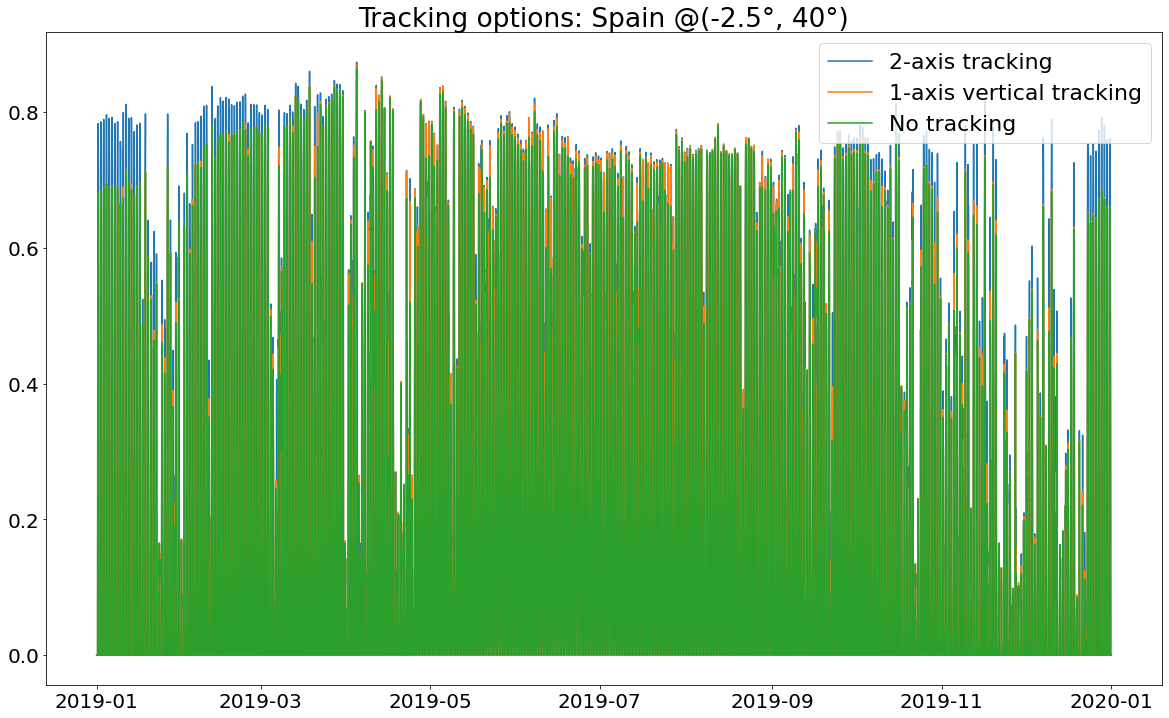

In [14]:
fig = plt.figure()
plt.plot(cap_factors_pv_2axis_df[point])
plt.plot(cap_factors_pv_1axis_df[point])
plt.plot(cap_factors_pv_0axis_df[point])


plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams.update({"font.size": 22})
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(["2-axis tracking", "1-axis vertical tracking", "No tracking"])
plt.title("Tracking options: Spain @(-2.5°, 40°)")

plt.show()